# MPAS Heat and Salt Budgets

***

In [1]:
import numpy as np
import xarray as xr
from datetime import datetime
from calendar import monthrange
from matplotlib import pyplot as plt
from cartopy import crs, feature
from tqdm import tqdm

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

In [2]:
# Define run and load example results file
startyear = 1948
restartyears = [11, 21]
prefix = 'timeMonthly_avg_'
resultspath = '/pscratch/sd/b/bmoorema/run_001_062/'
runID = '20210421_sim7_CORE_60to30E2r2.mpaso'
filename = f'{resultspath}{runID}.hist.am.timeSeriesStatsMonthly.0001-01-01.nc'
ds = xr.open_dataset(filename)

***

### Budget variables

In [3]:
# Budget variables (missing frazil)
varNames = {
    'T': {
        'HorzAdvT'  : 'activeTracerHorizontalAdvectionTendency_temperatureHorizontalAdvectionTendency',
        'VertAdvT'  : 'activeTracerVerticalAdvectionTendency_temperatureVerticalAdvectionTendency',
        'HorzMixT'  : 'activeTracerHorMixTendency_temperatureHorMixTendency',
        'VertMixT'  : 'activeTracerVertMixTendency_temperatureVertMixTendency',
        'SurfT'     : 'activeTracerSurfaceFluxTendency_temperatureSurfaceFluxTendency',
        'NonlocalT' : 'activeTracerNonLocalTendency_temperatureNonLocalTendency',
        'SWT'       : 'temperatureShortWaveTendency',
    },
    'S': {
        'HorzAdvS'  : 'activeTracerHorizontalAdvectionTendency_salinityHorizontalAdvectionTendency',
        'VertAdvS'  : 'activeTracerVerticalAdvectionTendency_salinityVerticalAdvectionTendency',
        'HorzMixS'  : 'activeTracerHorMixTendency_salinityHorMixTendency',
        'VertMixS'  : 'activeTracerVertMixTendency_salinityVertMixTendency',
        'SurfS'     : 'activeTracerSurfaceFluxTendency_salinitySurfaceFluxTendency',
        'NonlocalS' : 'activeTracerNonLocalTendency_salinityNonLocalTendency',
    },
}

Temperature budget variables

In [4]:
# Temperature budget
for varName, fullName in varNames['T'].items():
    attrs = ds[prefix + fullName].attrs
    long_name, units = attrs['long_name'], attrs['units']
    print(f'{varName:10s} {long_name:73s} {units}')

HorzAdvT   potential temperature tendency due to horizontal advection                degrees Celsius per second
VertAdvT   potential temperature tendency due to vertical advection                  degrees Celsius per second
HorzMixT   potential temperature tendency due to horizontal mixing (including Redi)  degrees Celsius per second
VertMixT   potential temperature tendency due to vertical mixing                     degrees Celsius per second
SurfT      potential temperature tendency due to surface fluxes                      degrees Celsius per second
NonlocalT  potential temperature tendency due to kpp non-local flux                  degrees Celsius per second
SWT        potential temperature tendency due to penetrating shortwave               degrees Celsius per second


Salinity budget variables

In [5]:
# Salinity budget
for varName, fullName in varNames['S'].items():
    attrs = ds[prefix + fullName].attrs
    long_name, units = attrs['long_name'], attrs['units']
    print(f'{varName:10s} {long_name:60s} {units}')

HorzAdvS   salinity tendency due to horizontal advection                PSU per second
VertAdvS   salinity tendency due to vertical advection                  PSU per second
HorzMixS   salinity tendency due to horizontal mixing (including Redi)  PSU per second
VertMixS   salinity tendency due to vertical mixing                     PSU per second
SurfS      salinity tendency due to surface fluxes                      PSU per second
NonlocalS  salinity tendency due to kpp non-local flux                  PSU per second


***

### Example location

Choose a point in the interior Atlantic

In [7]:
# Mesh cell to evaluate
nCell = 112846

# Get coordinates
filename = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
ds = xr.open_dataset(filename)
lon, lat = [np.rad2deg(ds[f'{name}Cell'][nCell].values) for name in ('lon', 'lat')]
lon = lon - 360
depth = ds.refBottomDepth.values
H_0 = ds.layerThickness[0, nCell, :].values

Show location on map

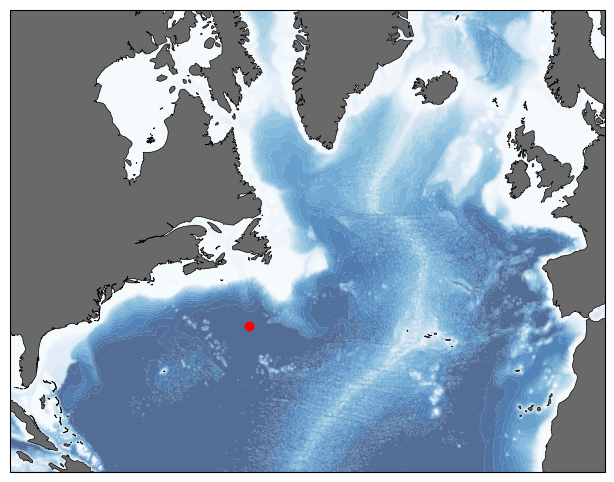

In [8]:
# Make map figure
proj, proj_ref = crs.LambertConformal(-40, 20), crs.PlateCarree()
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': proj})
ax.set_extent([-80, -10, 20, 70])

# Add land
ax.add_feature(feature.NaturalEarthFeature(
    'physical', 'land', '50m', color='dimgray', edgecolor='k', linewidth=0.5,
))

# Add bathymetry
filename = '/pscratch/sd/b/bmoorema/data/ETOPO_2022_v1_60s_N90W180_bed.nc'
ds = xr.open_dataset(filename).sel(lon=slice(-100, 31, 10), lat=slice(10, 81, 10))
x, y, z = [ds[name].values for name in ('lon', 'lat', 'z')]
c = ax.contourf(
    x, y, -z, levels=range(0, 5001, 250), cmap='Blues', extend='max',
    transform=proj_ref, zorder=-10, alpha=0.7, antialiased=True,
)

# Show mesh cell location
ax.plot(lon, lat, 'ro', transform=proj_ref)

***

### Budget calculation

**LHS** from restarts

In [9]:
# Initialize LHS as lists and define variable names
LHS = {'T': [], 'S': []}
names = 'temperature', 'salinity', 'layerThickness'

# Loop through adjacent restarts
for year in restartyears:

    # Load restart file and extract variables at nCell
    filename = f'{resultspath}{runID}.rst.{year:04d}-01-01_00000.nc'
    ds = xr.open_dataset(filename)
    T, S, H = [ds[name][0, nCell, :].values for name in names]

    # Update thickness-weighted profiles
    LHS['T'].append(T * H)
    LHS['S'].append(S * H)

# Get difference between restarts
LHS['T'] = LHS['T'][1] - LHS['T'][0]
LHS['S'] = LHS['S'][1] - LHS['S'][0]

**RHS** from budget tendency variables

In [10]:
# Initialize RHS and total_seconds to zero
RHS = {'T': 0, 'S': 0}
total_seconds = 0

# Loop through monthly files between restarts
for year in tqdm(range(*restartyears)):
    for month in range(1, 13):

        # Get seconds in month
        _, days = monthrange(year + startyear - 1, month)
        seconds = days * 86400

        # Load results file and extract layerThickness
        filename = f'{resultspath}{runID}.hist.am.timeSeriesStatsMonthly.{year:04d}-{month:02d}-01.nc'
        ds = xr.open_dataset(filename)
        H = ds[prefix + 'layerThickness'][0, nCell, :].values

        # Sum RHS terms for T and S, weight by layerThickness and seconds, add to running RHS
        for var in ['T', 'S']:
            sum_terms = sum(ds[prefix + name][0, nCell, :].values for name in varNames[var].values())
            RHS[var] = RHS[var] + sum_terms * H * seconds

        # Update total_seconds
        total_seconds += seconds

100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Calculate residual

In [11]:
# Calculate residual (frazil + monthly averaging of layerThickness)
RES = {var: (LHS[var] - RHS[var]) / (H_0 * total_seconds) for var in ['T', 'S']}

***

### Visualization

Remaining issues in the residual profiles
   * Upper layer noise outside of the frazil formation regions
   * Still some unexplained systematic residual in the interior

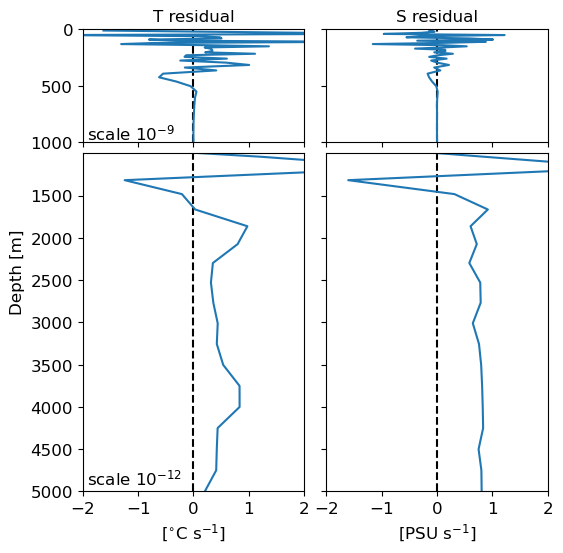

In [12]:
# Plot residual
gridspec_kw = {'height_ratios': [1, 3], 'hspace': 0.05, 'wspace': 0.1}
fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw=gridspec_kw)
xlabels = ['[$^{\\circ}$C s$^{-1}$]', '[PSU s$^{-1}$]']
for col, var, xlabel in zip(axs.T, ['T', 'S'], xlabels):
    col[0].set_title(f'{var} residual')
    col[0].xaxis.set_ticklabels('')
    col[1].set_xlabel(xlabel)
    for ax, power, ylim in zip(col, [9, 12], [(1000, 0), (5000, 1001)]):
        ax.plot([0, 0], ylim, 'k--')
        ax.plot(RES[var] * 2*10**power, depth)
        ax.set_xlim(-2, 2)
        ax.set_ylim(ylim)
        if var == 'T':
            ax.text(0.02, 0.02, f'scale $10^{{-{power}}}$', transform=ax.transAxes)
        else:
            ax.yaxis.set_ticklabels('')
axs[1, 0].set_ylabel('Depth [m]', y=0.65)
plt.show()